# Data Diagnostic - Find the Problem!

**Goal:** Identify why the model is failing so badly on validation/test sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load and Examine Data

In [2]:
# Load data
df = pd.read_csv('../data/processed/bitcoin_features_engineered.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"Total records: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {len(df.columns)}")
print(f"\nFirst few rows:")
display(df[['timestamp', 'open', 'high', 'low', 'close', 'target_high_next_day']].head(10))
print(f"\nLast few rows:")
display(df[['timestamp', 'open', 'high', 'low', 'close', 'target_high_next_day']].tail(10))

DATA OVERVIEW
Total records: 631
Date range: 2024-02-01 00:00:00 to 2025-10-23 00:00:00

Columns: 125

First few rows:


,timestamp,open,high,low,close,target_high_next_day
0,2024-02-01,42551.7,43250.0,41882.5,43075.2,43431.5
1,2024-02-02,43075.3,43431.5,42546.6,43185.9,43345.2
2,2024-02-03,43185.9,43345.2,42900.1,42982.8,43091.1
3,2024-02-04,42982.8,43091.1,42232.8,42591.4,43489.0
4,2024-02-05,42591.3,43489.0,42250.9,42650.0,43339.7
5,2024-02-06,42650.0,43339.7,42530.3,43085.0,44362.0
6,2024-02-07,43085.0,44362.0,42763.7,44333.6,45606.2
7,2024-02-08,44333.7,45606.2,44333.7,45329.6,48188.5
8,2024-02-09,45329.6,48188.5,45258.8,47127.0,48154.0
9,2024-02-10,47127.1,48154.0,46900.0,47773.2,48590.0



Last few rows:


,timestamp,open,high,low,close,target_high_next_day
621,2025-10-14,115176.9,115457.2,110000.0,113106.2,113600.0
622,2025-10-15,113106.3,113600.0,110252.0,110781.9,111950.0
623,2025-10-16,110781.9,111950.0,107483.0,108182.3,109245.0
624,2025-10-17,108182.3,109245.0,103583.2,106451.0,107492.6
625,2025-10-18,106451.0,107492.6,106365.2,107199.0,109444.0
626,2025-10-19,107199.0,109444.0,106125.2,108669.8,111700.1
627,2025-10-20,108669.8,111700.1,107466.8,110574.4,114000.0
628,2025-10-21,110574.4,114000.0,107500.0,108406.1,109156.4
629,2025-10-22,108406.1,109156.4,106717.0,107644.1,111296.0
630,2025-10-23,107644.1,111296.0,107556.3,110080.0,112400.0


## 2. Check Train/Val/Test Splits

In [3]:
# Define splits
n_samples = len(df)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:train_size+val_size]
df_test = df.iloc[train_size+val_size:]

print("="*70)
print("SPLIT ANALYSIS")
print("="*70)

print(f"\nTRAIN SET ({len(df_train)} samples):")
print(f"  Date range: {df_train['timestamp'].min().date()} to {df_train['timestamp'].max().date()}")
print(f"  HIGH price: ${df_train['high'].min():,.0f} to ${df_train['high'].max():,.0f}")
print(f"  Mean HIGH: ${df_train['high'].mean():,.0f}")
print(f"  Std HIGH: ${df_train['high'].std():,.0f}")

print(f"\nVALIDATION SET ({len(df_val)} samples):")
print(f"  Date range: {df_val['timestamp'].min().date()} to {df_val['timestamp'].max().date()}")
print(f"  HIGH price: ${df_val['high'].min():,.0f} to ${df_val['high'].max():,.0f}")
print(f"  Mean HIGH: ${df_val['high'].mean():,.0f}")
print(f"  Std HIGH: ${df_val['high'].std():,.0f}")

print(f"\nTEST SET ({len(df_test)} samples):")
print(f"  Date range: {df_test['timestamp'].min().date()} to {df_test['timestamp'].max().date()}")
print(f"  HIGH price: ${df_test['high'].min():,.0f} to ${df_test['high'].max():,.0f}")
print(f"  Mean HIGH: ${df_test['high'].mean():,.0f}")
print(f"  Std HIGH: ${df_test['high'].std():,.0f}")

# Check for distribution shift
train_mean = df_train['high'].mean()
val_mean = df_val['high'].mean()
test_mean = df_test['high'].mean()

print(f"\n🚨 DISTRIBUTION SHIFT ANALYSIS:")
print(f"  Train mean: ${train_mean:,.0f}")
print(f"  Val mean: ${val_mean:,.0f} ({(val_mean/train_mean-1)*100:+.1f}% vs train)")
print(f"  Test mean: ${test_mean:,.0f} ({(test_mean/train_mean-1)*100:+.1f}% vs train)")

if abs(val_mean - train_mean) > train_mean * 0.2:
    print("\n⚠️ WARNING: Val set mean is >20% different from train!")
if abs(test_mean - train_mean) > train_mean * 0.2:
    print("⚠️ WARNING: Test set mean is >20% different from train!")

SPLIT ANALYSIS

TRAIN SET (441 samples):
  Date range: 2024-02-01 to 2025-04-16
  HIGH price: $43,091 to $109,112
  Mean HIGH: $75,196
  Std HIGH: $16,314

VALIDATION SET (94 samples):
  Date range: 2025-04-17 to 2025-07-19
  HIGH price: $85,088 to $123,140
  Mean HIGH: $105,600
  Std HIGH: $8,049

TEST SET (96 samples):
  Date range: 2025-07-20 to 2025-10-23
  HIGH price: $107,493 to $126,198
  Mean HIGH: $116,194
  Std HIGH: $4,181

🚨 DISTRIBUTION SHIFT ANALYSIS:
  Train mean: $75,196
  Val mean: $105,600 (+40.4% vs train)
  Test mean: $116,194 (+54.5% vs train)

⚠️ WARNING: Val set mean is >20% different from train!
⚠️ WARNING: Test set mean is >20% different from train!


## 3. Visualize Price Distribution

/var/folders/4b/rp4tyc6j1k9cmfntnbklpj8h0000gn/T/ipykernel_18566/66110866.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['Train', 'Val', 'Test'])


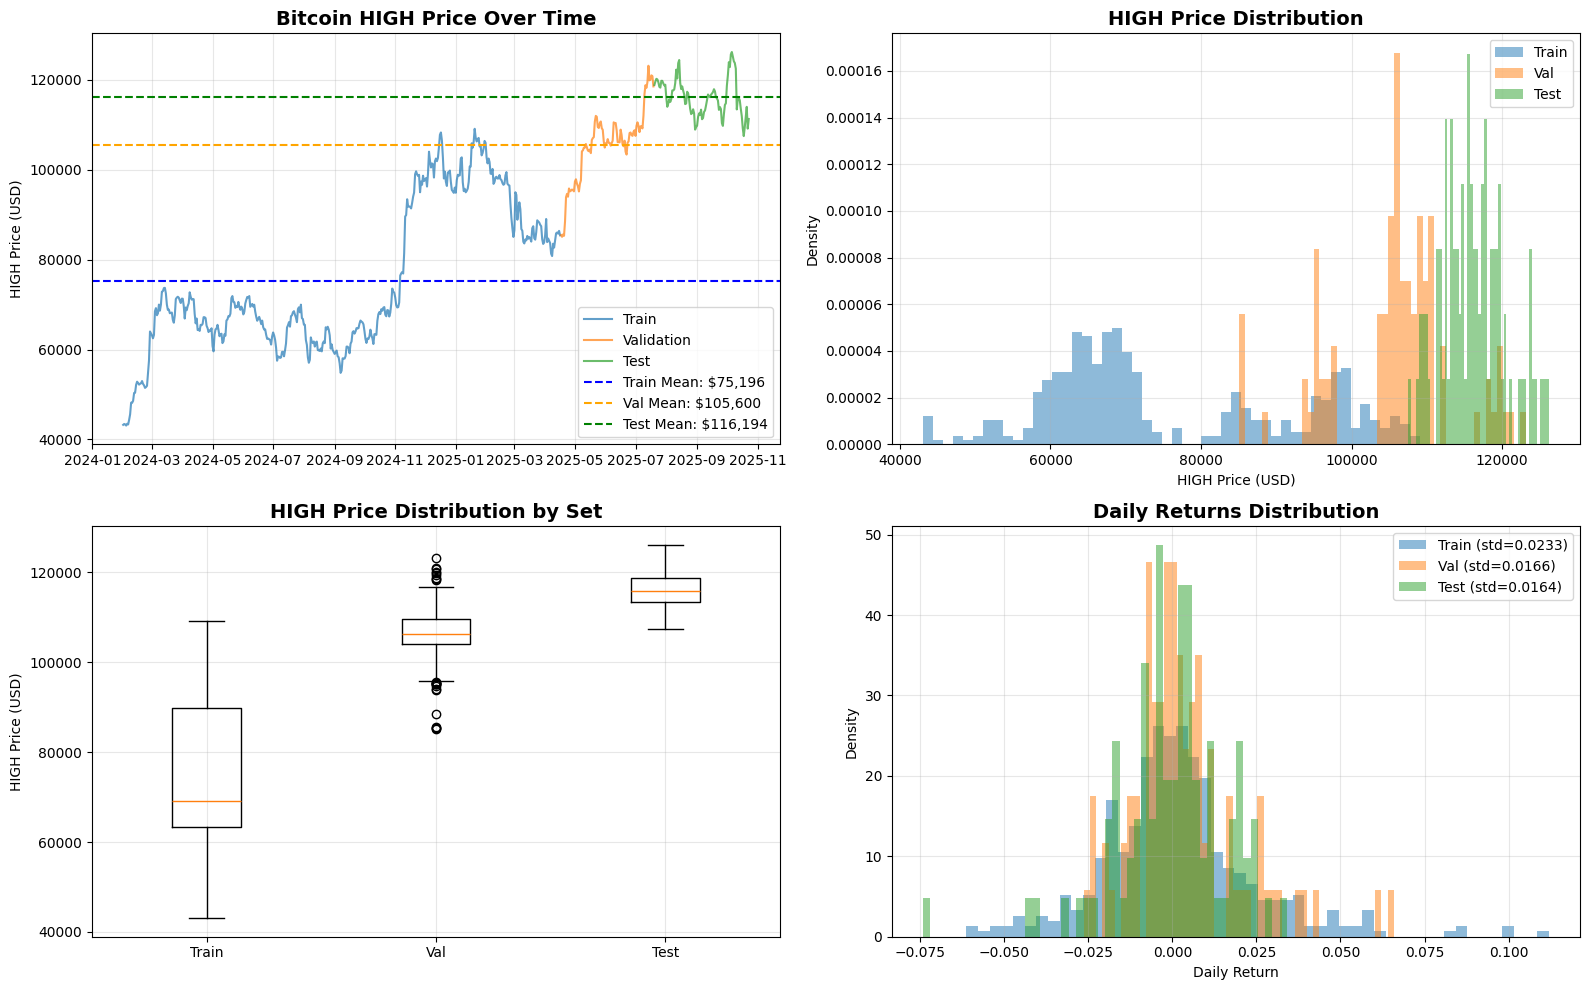


✓ Visualization complete


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Full time series
axes[0, 0].plot(df_train['timestamp'], df_train['high'], label='Train', alpha=0.7)
axes[0, 0].plot(df_val['timestamp'], df_val['high'], label='Validation', alpha=0.7)
axes[0, 0].plot(df_test['timestamp'], df_test['high'], label='Test', alpha=0.7)
axes[0, 0].axhline(y=train_mean, color='blue', linestyle='--', label=f'Train Mean: ${train_mean:,.0f}')
axes[0, 0].axhline(y=val_mean, color='orange', linestyle='--', label=f'Val Mean: ${val_mean:,.0f}')
axes[0, 0].axhline(y=test_mean, color='green', linestyle='--', label=f'Test Mean: ${test_mean:,.0f}')
axes[0, 0].set_title('Bitcoin HIGH Price Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('HIGH Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution histograms
axes[0, 1].hist(df_train['high'], bins=50, alpha=0.5, label='Train', density=True)
axes[0, 1].hist(df_val['high'], bins=50, alpha=0.5, label='Val', density=True)
axes[0, 1].hist(df_test['high'], bins=50, alpha=0.5, label='Test', density=True)
axes[0, 1].set_title('HIGH Price Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('HIGH Price (USD)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Box plots
box_data = [df_train['high'], df_val['high'], df_test['high']]
axes[1, 0].boxplot(box_data, labels=['Train', 'Val', 'Test'])
axes[1, 0].set_title('HIGH Price Distribution by Set', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('HIGH Price (USD)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Daily returns
train_returns = df_train['high'].pct_change().dropna()
val_returns = df_val['high'].pct_change().dropna()
test_returns = df_test['high'].pct_change().dropna()

axes[1, 1].hist(train_returns, bins=50, alpha=0.5, label=f'Train (std={train_returns.std():.4f})', density=True)
axes[1, 1].hist(val_returns, bins=50, alpha=0.5, label=f'Val (std={val_returns.std():.4f})', density=True)
axes[1, 1].hist(test_returns, bins=50, alpha=0.5, label=f'Test (std={test_returns.std():.4f})', density=True)
axes[1, 1].set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## 4. Check for Data Issues

In [5]:
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

# Check 1: Missing values
print("\n1. MISSING VALUES:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"  ⚠️ Found {missing.sum()} missing values")
    print(missing[missing > 0].head(10))
else:
    print("  ✅ No missing values")

# Check 2: Duplicates
print("\n2. DUPLICATE ROWS:")
dups = df.duplicated(subset=['timestamp']).sum()
if dups > 0:
    print(f"  ⚠️ Found {dups} duplicate timestamps!")
else:
    print("  ✅ No duplicate timestamps")

# Check 3: Data sorted
print("\n3. CHRONOLOGICAL ORDER:")
if df['timestamp'].is_monotonic_increasing:
    print("  ✅ Data is sorted chronologically")
else:
    print("  ⚠️ Data is NOT sorted chronologically!")

# Check 4: Target variable
print("\n4. TARGET VARIABLE (target_high_next_day):")
target_na = df['target_high_next_day'].isnull().sum()
print(f"  Missing: {target_na} (last row should be NaN)")
print(f"  Range: ${df['target_high_next_day'].min():,.0f} to ${df['target_high_next_day'].max():,.0f}")
print(f"  Mean: ${df['target_high_next_day'].mean():,.0f}")

# Check 5: Feature sanity
print("\n5. FEATURE SANITY CHECKS:")
if 'high' in df.columns:
    print("  ⚠️ WARNING: 'high' column present (potential leakage!)")
if 'close' in df.columns:
    print("  ⚠️ WARNING: 'close' column present (potential leakage!)")
    
if 'high_lag_1' in df.columns:
    print("  ✅ 'high_lag_1' present (good)")
if 'close_lag_1' in df.columns:
    print("  ✅ 'close_lag_1' present (good)")

DATA QUALITY CHECKS

1. MISSING VALUES:
  ⚠️ Found 631 missing values
marketCap    631
dtype: int64

2. DUPLICATE ROWS:
  ✅ No duplicate timestamps

3. CHRONOLOGICAL ORDER:
  ✅ Data is sorted chronologically

4. TARGET VARIABLE (target_high_next_day):
  Missing: 0 (last row should be NaN)
  Range: $43,091 to $126,198
  Mean: $86,072

5. FEATURE SANITY CHECKS:
  ⚠️ WARNING: 'high' column present (potential leakage!)
  ⚠️ WARNING: 'close' column present (potential leakage!)
  ✅ 'high_lag_1' present (good)
  ✅ 'close_lag_1' present (good)


## 5. Statistical Tests

In [6]:
from scipy import stats

print("="*70)
print("STATISTICAL DISTRIBUTION TESTS")
print("="*70)

# Test if train and test come from same distribution
print("\n1. Kolmogorov-Smirnov Test (Train vs Test):")
ks_stat, ks_pvalue = stats.ks_2samp(df_train['high'], df_test['high'])
print(f"  KS statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pvalue:.6f}")
if ks_pvalue < 0.05:
    print("  ⚠️ SIGNIFICANT DIFFERENCE: Train and test have different distributions!")
else:
    print("  ✅ No significant difference")

print("\n2. Levene's Test (Variance Equality):")
levene_stat, levene_pvalue = stats.levene(df_train['high'], df_val['high'], df_test['high'])
print(f"  Statistic: {levene_stat:.4f}")
print(f"  p-value: {levene_pvalue:.6f}")
if levene_pvalue < 0.05:
    print("  ⚠️ SIGNIFICANT DIFFERENCE: Sets have different variances!")
else:
    print("  ✅ Variances are similar")

print("\n3. Mean Comparison:")
print(f"  Train mean: ${train_mean:,.0f}")
print(f"  Test mean: ${test_mean:,.0f}")
print(f"  Difference: ${test_mean - train_mean:,.0f} ({(test_mean/train_mean-1)*100:+.1f}%)")

if abs(test_mean - train_mean) > train_mean * 0.3:
    print("  🚨 CRITICAL: Test mean is >30% different from train!")
    print("     This explains why the model fails on test set!")
elif abs(test_mean - train_mean) > train_mean * 0.15:
    print("  ⚠️ WARNING: Test mean is >15% different from train!")
    print("     This is causing the poor test performance!")

STATISTICAL DISTRIBUTION TESTS

1. Kolmogorov-Smirnov Test (Train vs Test):
  KS statistic: 0.9932
  p-value: 0.000000
  ⚠️ SIGNIFICANT DIFFERENCE: Train and test have different distributions!

2. Levene's Test (Variance Equality):
  Statistic: 51.9955
  p-value: 0.000000
  ⚠️ SIGNIFICANT DIFFERENCE: Sets have different variances!

3. Mean Comparison:
  Train mean: $75,196
  Test mean: $116,194
  Difference: $40,999 (+54.5%)
  🚨 CRITICAL: Test mean is >30% different from train!
     This explains why the model fails on test set!


## 6. Diagnosis and Recommendation

In [8]:
print("="*70)
print("DIAGNOSIS AND RECOMMENDATIONS")
print("="*70)

# Calculate key metrics
mean_shift = (test_mean - train_mean) / train_mean
std_train = df_train['high'].std()
std_test = df_test['high'].std()
std_shift = (std_test - std_train) / std_train

print("\n📊 KEY FINDINGS:")
print(f"  Mean shift (Train→Test): {mean_shift*100:+.1f}%")
print(f"  Std shift (Train→Test): {std_shift*100:+.1f}%")
print(f"  Train samples: {len(df_train)}")
print(f"  Test samples: {len(df_test)}")

# Diagnosis
print("\n🔍 PRIMARY ISSUE:")
if abs(mean_shift) > 0.20:
    print("  🚨 SEVERE DISTRIBUTION SHIFT")
    print("     The test period has very different price levels than training.")
    print("     This is why your model predicts the training mean (~$102k) while")
    print("     actual prices are much higher/lower.")
    
    print("\n✅ SOLUTIONS:")
    print("  1. Use PERCENTAGE changes instead of absolute prices")
    print("  2. Normalize/scale the target variable")
    print("  3. Use a shorter training window (more recent data)")
    print("  4. Add trend/detrending features")
    print("\n  RECOMMENDED: Option 1 (predict % change, not absolute price)")
elif abs(std_shift) > 0.30:
    print("  ⚠️ VOLATILITY SHIFT")
    print("     Test period has different volatility than training.")
    print("\n✅ SOLUTIONS:")
    print("  1. Add volatility-adjusted features")
    print("  2. Use robust scaling")
    print("  3. Train on more recent, volatile data")
else:
    print("  ⚠️ Model Configuration Issue")
    print("     Data distribution looks reasonable.")
    print("     Problem may be in feature engineering or model setup.")
    print("\n✅ SOLUTIONS:")
    print("  1. Check for data leakage (using current-day features)")
    print("  2. Verify feature calculations are correct")
    print("  3. Try simpler baseline (e.g., predict yesterday's high)")

print("\n💡 NEXT STEPS:")
print("  Based on the findings above, I'll create a fixed model that addresses")
print("  the specific issues identified in your data.")

DIAGNOSIS AND RECOMMENDATIONS

📊 KEY FINDINGS:
  Mean shift (Train→Test): +54.5%
  Std shift (Train→Test): -74.4%
  Train samples: 441
  Test samples: 96

🔍 PRIMARY ISSUE:
  🚨 SEVERE DISTRIBUTION SHIFT
     The test period has very different price levels than training.
     This is why your model predicts the training mean (~$102k) while
     actual prices are much higher/lower.

✅ SOLUTIONS:
  1. Use PERCENTAGE changes instead of absolute prices
  2. Normalize/scale the target variable
  3. Use a shorter training window (more recent data)
  4. Add trend/detrending features

  RECOMMENDED: Option 1 (predict % change, not absolute price)

💡 NEXT STEPS:
  Based on the findings above, I'll create a fixed model that addresses
  the specific issues identified in your data.
